In [28]:
import qutip as qt
import scqubits as scq
import numpy as np

import matplotlib.pyplot as plt

In [29]:
fluxonium = scq.Fluxonium(EJ = 8.9,
                               EC = 2.5,
                               EL = 0.5,
                               flux = 0.33,
                               cutoff = 110) #default tutorial parameters

levels = 6

evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_flux = fluxonium.n_operator()
n_op_energy = qt.Qobj(evecs.conj().T @ n_op_flux @ evecs) # energy basis conversion

print(n_op_energy.shape) 

n_op_energy_basis = fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs))

n_op_energy_basis = qt.Qobj(n_op_energy_basis)

H0 = qt.Qobj(np.diag(evals))

A = 0.1 # also defined above
drive_op = n_op_energy_basis
# drive_op = n_op_energy   # this is the one that works  
omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

drive_op

(6, 6)


Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-3.22585366e-18j 0.-5.66262318e-02j 0.-4.56401197e-01j
  0.-1.83445582e-01j 0.+1.10035694e-01j 0.-2.77944704e-02j]
 [0.+5.66262318e-02j 0.-1.61872919e-17j 0.+2.64320488e-01j
  0.-3.65141796e-01j 0.+1.54440777e-01j 0.+1.61719812e-01j]
 [0.+4.56401197e-01j 0.-2.64320488e-01j 0.+8.59076701e-18j
  0.+4.03279900e-01j 0.-4.25158508e-02j 0.+2.32905015e-01j]
 [0.+1.83445582e-01j 0.+3.65141796e-01j 0.-4.03279900e-01j
  0.+2.58982127e-18j 0.+2.04656212e-01j 0.+4.85832987e-01j]
 [0.-1.10035694e-01j 0.-1.54440777e-01j 0.+4.25158508e-02j
  0.-2.04656212e-01j 0.+2.59909506e-17j 0.-4.83263585e-01j]
 [0.+2.77944704e-02j 0.-1.61719812e-01j 0.-2.32905015e-01j
  0.-4.85832987e-01j 0.+4.83263585e-01j 0.-9.13088447e-18j]]

In [30]:
psi_initial = qt.basis(levels, 0)

psi_initial

Quantum object: dims=[[6], [1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [31]:
projectors = []

for i in range(levels):
    proj = qt.basis(levels, i) * qt.basis(levels, i).dag()
    projectors.append(proj)

# projectors

In [32]:
times = np.linspace(0, 3000, 10000)

options = qt.Options(nsteps=1000000, store_states=True, atol=1e-8, rtol=1e-6)

result_levels = qt.mesolve(
    H, psi_initial, times, [],
    projectors,
    args=args, options=options
)

result_levels

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\options.py: 16FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

<Result
  Solver: sesolve
  Solver stats:
    method: 'scipy zvode adams'
    init time: 0.0
    preparation time: 0.00099945068359375
    run time: 1.9289648532867432
    solver: 'Schrodinger Evolution'
  Time interval: [0.0, 3000.0] (10000 steps)
  Number of e_ops: 6
  States saved.
>

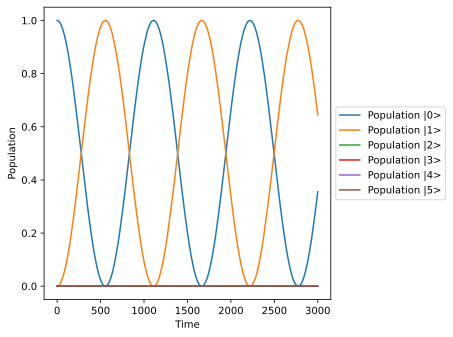

In [33]:
for i in range(levels):
    plt.plot(times, result_levels.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Timing

In [34]:
d01 = abs(n_op_energy[0, 1])

rabi_freq = A * d01

tx = np.pi / rabi_freq

tx

554.7945810895404

 c:\Users\Owner\anaconda3\Lib\site-packages\qutip\solver\solver_base.py: 576

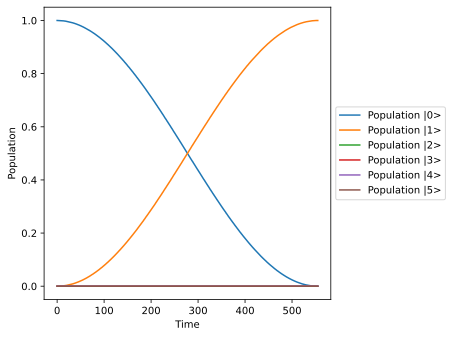

In [35]:
x_test_times = np.linspace(0, tx, 1000) 

result_levels_x_time = qt.mesolve(
    H, psi_initial, x_test_times, [],
    projectors,
    args=args, options=options
)

for i in range(levels):
    plt.plot(x_test_times, result_levels_x_time.expect[i], label=f'Population |{i}>')

plt.xlabel('Time')
plt.ylabel('Population')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  
plt.show()

## Propagator

In [36]:
U = qt.propagator(H, tx, args=args, options=options)

## Fidelity

In [37]:
X_ideal = qt.qeye(levels)
X_ideal = X_ideal.full()

X_ideal[0, 0] = 0
X_ideal[1, 1] = 0
X_ideal[0, 1] = 1
X_ideal[1, 0] = 1

X_ideal = qt.Qobj(X_ideal)

X_ideal

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [38]:
#redefine the Hamiltonian with the correct drive amplitude

n_op_energy_basis = fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs))
n_op_energy_basis = qt.Qobj(n_op_energy_basis)
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
omega_d = evals[1] - evals[0]
H = [H0, [A * drive_op, 'cos(wd * t)']]
args = {'wd': omega_d}

In [41]:
U = qt.propagator(H, tx, args=args, options=options)

U

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-4.37339845e-04+2.68707079e-03j  9.73627167e-01+2.27980328e-01j
   2.42845008e-03-6.45450391e-03j -1.22381866e-03+4.04025805e-03j
   4.84220200e-04-1.03212917e-03j  1.68498809e-04-9.84464898e-04j]
 [-6.22716844e-01+7.82417299e-01j -2.01494935e-03-1.80810683e-03j
  -5.59755788e-03-1.16521162e-03j -2.02715261e-03+8.37723002e-04j
   8.42139049e-04+1.07962362e-03j  3.84483682e-04-1.20587179e-04j]
 [-2.80044168e-03+5.09716029e-03j -3.41628715e-04-6.74796337e-03j
   9.96676099e-01+4.84685587e-02j  3.15501321e-02-5.40526743e-02j
   2.78236662e-04+3.18361112e-04j -2.59127707e-03-5.97926836e-03j]
 [ 1.58608775e-03-1.01638994e-03j  1.97734433e-04-4.44930890e-03j
   2.76434749e-02+5.61900175e-02j -9.96754918e-01-2.40869759e-02j
   3.68138342e-03-9.59251669e-03j  6.91295755e-03+1.52338875e-02j]
 [-1.25827539e-03-5.76840140e-04j -1.02294297e-03-4.72681994e-04j
  -1.04174168e-05-2.24804293e-04j  9.826

In [40]:
fidelity = qt.fidelity(U, X_ideal)

print("State gate fidelity:", fidelity)

fidelity = qt.average_gate_fidelity(U, X_ideal)

print("Average gate fidelity:", fidelity)

State gate fidelity: 2.8935967602694888
Average gate fidelity: 0.15834512627695285
